In [5]:
import torch                    
import torch.nn as nn           
import torch.optim as optim     
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader  
import pandas as pd               
import numpy as np                
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error   
import matplotlib.pyplot as plt  

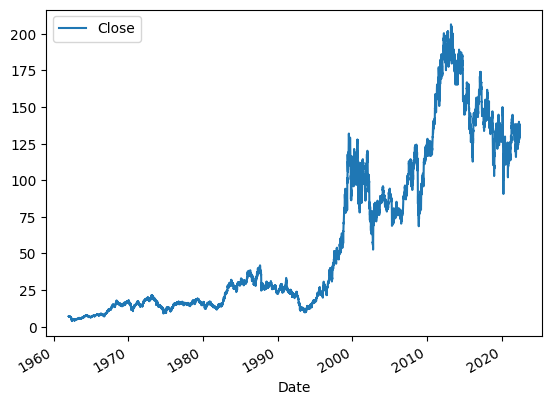

In [6]:
df = pd.read_csv('./data/ibm.csv', usecols=['Date', 'Close'], index_col='Date', parse_dates=True)
df.plot()
plt.show()

In [7]:
data = df.asfreq('D', method = 'ffill').values.astype('float32')

## Normalization
The goal of normalization is to transform features to be on a similar scale. This improves the performance and training stability of the model. See:

In [86]:
# scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.01675168],
       [0.01706656],
       [0.01670445],
       ...,
       [0.6375177 ],
       [0.6213129 ],
       [0.6154831 ]], dtype=float32)

## Splitting Data

In [87]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
train = data_scaled[0:train_size, :]
test = data_scaled[train_size:len(data_scaled), :]

## Converting time series data into supervised machine learning format
To convert time series data into supervised machine learning format, we can use the sliding window technique. This involves dividing the time series into smaller, fixed-length subsequences and using them to create a matrix and target variable.

Let's say we have a sequence of length 10: `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`
If we set a window size of 3 and slide the window across the sequence, we would get the following subsets:
<code>
X     -> y
1 2 3 -> 4
2 3 4 -> 5
3 4 5 -> 6
4 5 6 -> 7
5 6 7 -> 8
6 7 8 -> 9
7 8 9 -> 10
</code>

In [88]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size=10):
    # Initialize empty lists to store the input and output data.
    x_data, y_data = [], []
    # Iterate over the length of the dataset minus the window size.
    for i in range(len(dataset) - window_size):
        # Slice the dataset to extract the window of data.
        a = dataset[i:(i+window_size), 0]
        # Append the window of data to the input data list.
        x_data.append(a)
        # Append the next value (target) in the time series to the output data list.
        y_data.append(dataset[i + window_size, 0])
    # Return the input and output data as numpy arrays.
    return np.array(x_data), np.array(y_data)

window_size = 50
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

## Writing custom dataset
We typically need to preprocess the data in a way that is appropriate for the chosen model. By creating a custom dataset, we can easily load and use the data using the `DataLoader` class.

In [89]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # convert `x` into [batch, sequence, features] for LSTM
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset_train = TimeSeriesDataset(X_train, y_train)
dataset_test = TimeSeriesDataset(X_test, y_test)
print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (17593, 50, 1) (17593,)
Test data shape (4361, 50, 1) (4361,)


## Define LSTM model

In [90]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU() # ReLU activation function
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout) # dropout layer to prevent overfitting
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
         # initialize the weights of the LSTM layer
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

## Train the model


In [91]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(device)
        y = y.to(device)

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    return epoch_loss

In [97]:
# Define hyperparameters
input_size = 1
hidden_dim = 32
batch_size = 64
output_dim = 1
num_layers = 2
lr = 0.001
num_epoch = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = LSTMModel(input_size, hidden_dim, num_layers, output_dim)
model = model.to(device)

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=batch_size)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# begin training
train_loss = []
test_loss = []
for epoch in range(num_epoch):
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    train_loss.append(loss_train)
    test_loss.append(loss_val)
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, num_epoch, loss_train, loss_val))

Epoch[1/40] | loss train:0.011229, test:0.047756
Epoch[2/40] | loss train:0.023222, test:0.031774
Epoch[3/40] | loss train:0.032073, test:0.021917
Epoch[4/40] | loss train:0.024904, test:0.015310
Epoch[5/40] | loss train:0.013178, test:0.012955
Epoch[6/40] | loss train:0.005980, test:0.008897
Epoch[7/40] | loss train:0.003040, test:0.006796
Epoch[8/40] | loss train:0.001988, test:0.004304
Epoch[9/40] | loss train:0.001755, test:0.002409
Epoch[10/40] | loss train:0.001522, test:0.003261
Epoch[11/40] | loss train:0.001254, test:0.002008
Epoch[12/40] | loss train:0.001315, test:0.002042
Epoch[13/40] | loss train:0.001060, test:0.001350
Epoch[14/40] | loss train:0.001129, test:0.001815
Epoch[15/40] | loss train:0.000947, test:0.002487
Epoch[16/40] | loss train:0.000962, test:0.002308
Epoch[17/40] | loss train:0.001105, test:0.001920
Epoch[18/40] | loss train:0.001138, test:0.002331
Epoch[19/40] | loss train:0.001185, test:0.001895
Epoch[20/40] | loss train:0.001370, test:0.001023
Epoch[21/

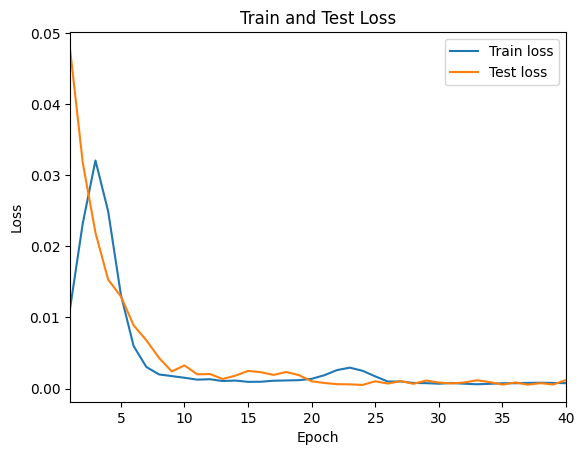

In [98]:
epochs = range(1, len(train_loss)+1)

# Plot the train and test loss
plt.plot(epochs, train_loss, label='Train loss')
plt.plot(epochs, test_loss, label='Test loss')
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, len(train_loss))
plt.legend()

plt.savefig('loss.pdf', format="pdf", bbox_inches='tight')

plt.show()

In [101]:
# Test the model
with torch.no_grad():
    y_pred = model(torch.from_numpy(dataset_test.x))
    
# Compute MSE
mse = criterion(y_pred, torch.as_tensor(dataset_test.y))
print(f'Test score: {mse.item():.6f} MSE')

Test score: 0.001110 MSE


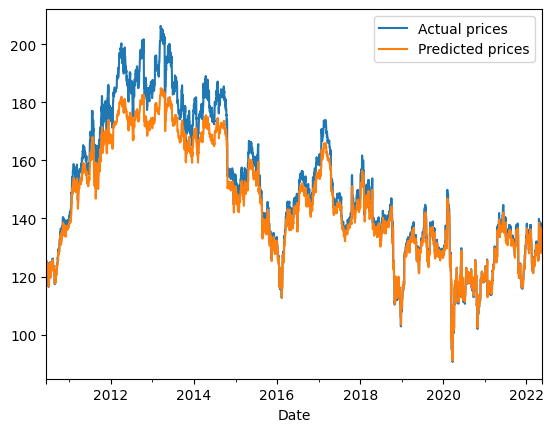

In [102]:
# create a dictionary with the actual prices and predicted prices
actual = scaler.inverse_transform(dataset_test.y.reshape(-1, 1))
predictions = scaler.inverse_transform(y_pred.reshape(-1, 1))
d = {'Actual prices': actual.ravel(), 'Predicted prices': predictions.ravel()}

# create a pandas DataFrame from the dictionary, and set 'Date' column as index
ddf = pd.DataFrame(data=d).set_index(df[train_size+window_size:].index)
ddf.plot()
plt.savefig('actual-predictions.pdf', format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), './trained_model/lstm_model.pt')